# 1. Понимание задачи и данных

 **Цель соревнования**: Предсказать итоговую цену продажи каждого дома по 79 признакам, описывающим различные аспекты жилых домов.

 **Метрика оценки**: Root-Mean-Squared-Error (RMSE) между логарифмом предсказанной цены и логарифмом наблюдаемой цены.
 $$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(y_i) - \log(\hat{y}_i))^2} $$

 **Данные**:
 - `train.csv` - обучающая выборка с целевой переменной `SalePrice`
 - `test.csv` - тестовая выборка без целевой переменной
 - `data_description.txt` - описание всех признаков 
 - `sample_submission.csv` - пример файла для отправки

# 2. Импорт библиотек

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Для машинного обучения
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import optuna

# Для статистики
from scipy import stats
from scipy.stats import skew, norm

# Настройка визуализаций
plt.style.use('ggplot')  # Используем стиль ggplot для графиков
sns.set_palette("husl")  # Устанавливаем цветовую палитру

# 3. ЗАГРУЗКА ДАННЫХ

In [33]:
# Читаем данные из csv файлов
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Объединим train и test для согласованной обработки
# Чтобы все преобразования (заполнение пропусков, кодирование)
# были одинаковыми для обеихвыборок
data = pd.concat([train.drop(columns=['SalePrice'], axis=1), test], ignore_index=True)
data = data.drop(columns=['Id'], axis=1)

# Сохраним id тестовой и обучающей выборки 
train_idx = range(len(train) )
test_idx = range(len(train), len(data))

# Отдельно сохраним целевую переменную
y = train['SalePrice']
print(f"Размер обучающей выборки: {train.shape}")  # (1460, 81) - 1460 строк, 81 столбец
print(f"Размер тестовой выборки: {test.shape}")    # (1459, 80) - 1459 строк, 80 столбцов (без SalePrice)
print(f"Размер объединенных данных: {data.shape}") # (2919, 80) - сумма строк, все признаки кроме SalePrice
print(train.head())

print(train_idx)
print(test_idx)

Размер обучающей выборки: (1460, 81)
Размер тестовой выборки: (1459, 80)
Размер объединенных данных: (2919, 79)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0 

# 4. ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ

## 4.1. Исследование структуры данных

In [34]:
# Метод info() показывает информацию о DataFrame:
# - Количество строк и столбцов
# - Типы данных каждого столбца
# - Количество непустых значений
print("Информация о данных (train.csv):")
print(train.info())

# Метод describe() показывает статистики для числовых столбцов:
# - count: количество непустых значений
# - mean: среднее значение
# - std: стандартное отклонение
# - min, 25%, 50%, 75%, max: минимальное, квартили, максимальное
print("\nОсновные статистики для числовых признаков:")
display(train.describe())

# Посмотрим на категориальные признаки
# select_dtypes выбирает столбцы определенного типа
categorical_cols = train.select_dtypes(include=['object']).columns
print(f"\nКоличество категориальных признаков: {len(categorical_cols)}")
print("Примеры категориальных признаков:", list(categorical_cols[:5]))

Информация о данных (train.csv):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



Количество категориальных признаков: 43
Примеры категориальных признаков: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']


## 4.2. Анализ целевой переменной (SalePrice)

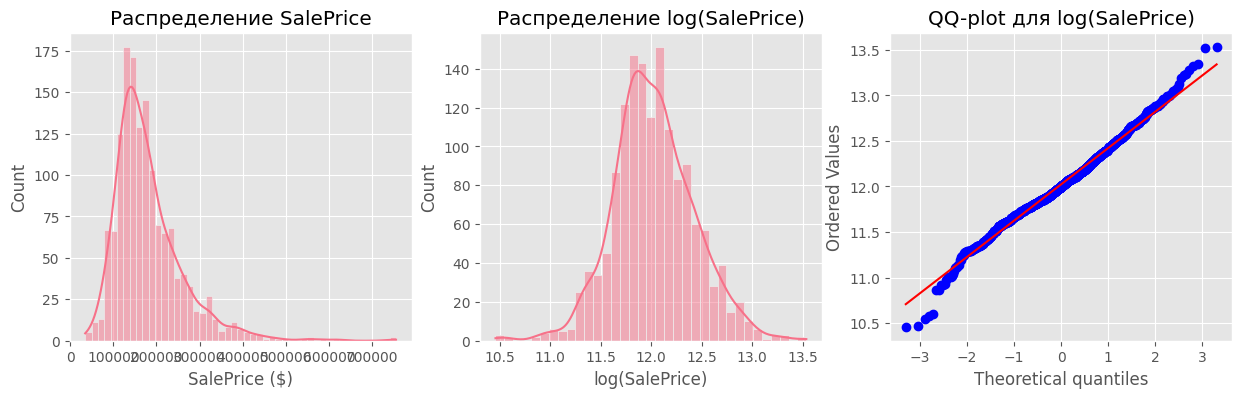

Средняя цена дома: $180,921.20
Медианная цена: $163,000.00
Стандартное отклонение: $79,442.50
Минимальная цена: $34,900.00
Максимальная цена: $755,000.00

Асимметрия исходной цены: 1.8809
Асимметрия после логарифмирования: 0.1212

Корреляция с SalePrice:
SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64


In [35]:
# Создаем графики для анализа распределения Saleprice
fig, axes = plt.subplots(1, 3, figsize=(15,4))

# 1. Гистограмма исходной цены 
sns.histplot(y, kde=True, ax=axes[0])
# kde=True - добавляет ядерную оценку плотности (сглаженную кривую)
axes[0].set_title('Распределение SalePrice')
axes[0].set_xlabel('SalePrice ($)')

# 2. Гистограмма логарифма цены 
sns.histplot(np.log1p(y), kde=True, ax=axes[1])
# np.log1p(x) = log(x + 1) - логарифм с защитой от нуля
axes[1].set_title('Распределение log(SalePrice)')
axes[1].set_xlabel('log(SalePrice)')

# 3. QQ-plot для проверки нормальности 
stats.probplot(np.log1p(y), plot=axes[2])
# QQ-plot сравнивает распределение данных с нормальным
# Если точки лежат на прямой линии - распределение нормальное
axes[2].set_title('QQ-plot для log(SalePrice)')

plt.show()

# Выводим статистики
print(f"Средняя цена дома: ${y.mean():,.2f}")
print(f"Медианная цена: ${y.median():,.2f}")
print(f"Стандартное отклонение: ${y.std():,.2f}")
print(f"Минимальная цена: ${y.min():,.2f}")
print(f"Максимальная цена: ${y.max():,.2f}")

# Коэффициент асимметрии (skewness)
# skew > 0 - распределение смещено вправо (длинный хвост справа)
# skew < 0 - распределение смещено влево
# skew ≈ 0 - симметричное распределение
print(f"\nАсимметрия исходной цены: {skew(y):.4f}")
print(f"Асимметрия после логарифмирования: {skew(np.log1p(y)):.4f}")

# Проверяем коррелляцию с некоторыми важными признаками 
correlations = train[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'SalePrice']].corr()
print("\nКорреляция с SalePrice:")
print(correlations['SalePrice'].sort_values(ascending=False))

# 5. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ (MISSING VALUES)

In [36]:
# sum() подсчитывает количество True (пропусков) в каждом столбце
missing = data.isnull().sum()

# Выбираем только столбцы где есть пропуски 
missing = missing[missing > 0]

# Вычисляем процент пропусков
missing_percent = (missing / len(data)) * 100

# Создаем красивую таблицу с результатами 
missing_df = pd.DataFrame({"Количество пропусков": missing,
                           "Процент пропусков": missing_percent
}).sort_values("Количество пропусков",ascending=False)

print("Признаки с пропущенными значениями (отсортировано по убыванию):")
display(missing_df.head(20))

# Анализируем самые проблемные признаки
print("\nАнализ признаков с большим процентом пропусков:")
for col in missing_df.index[:5]:
    print(f"\n{col}:")
    print(f"  Пропусков: {missing_df.loc[col, 'Количество пропусков']}")
    print(f"  Процент: {missing_df.loc[col, 'Процент пропусков']:.1f}%")
    print(f"  Тип данных: {data[col].dtype}")
    if data[col].dtype == 'object':  # Если категориальный признак
        print(f"  Уникальные значения: {data[col].unique()[:5]}")  # Первые 5 уникальных значений

Признаки с пропущенными значениями (отсортировано по убыванию):


,Количество пропусков,Процент пропусков
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
MasVnrType,1766,60.500171
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageQual,159,5.447071
GarageYrBlt,159,5.447071
GarageCond,159,5.447071



Анализ признаков с большим процентом пропусков:

PoolQC:
  Пропусков: 2909
  Процент: 99.7%
  Тип данных: object
  Уникальные значения: [nan 'Ex' 'Fa' 'Gd']

MiscFeature:
  Пропусков: 2814
  Процент: 96.4%
  Тип данных: object
  Уникальные значения: [nan 'Shed' 'Gar2' 'Othr' 'TenC']

Alley:
  Пропусков: 2721
  Процент: 93.2%
  Тип данных: object
  Уникальные значения: [nan 'Grvl' 'Pave']

Fence:
  Пропусков: 2348
  Процент: 80.4%
  Тип данных: object
  Уникальные значения: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']

MasVnrType:
  Пропусков: 1766
  Процент: 60.5%
  Тип данных: object
  Уникальные значения: ['BrkFace' nan 'Stone' 'BrkCmn']


# 6. ИНЖЕНЕРИЯ ПРИЗНАКОВ И ОБРАБОТКА ПРОПУСКОВ

## 6.1. Заполнение пропусков на основе доменного знания

In [37]:
# Создаем копию данных для обработки
# .copy() создает глубокую копию, чтобы не изменять исходные данные
data_processed = data.copy()

# ГРУППА 1: Признаки, где 'NA' означает "Нет" (отсутствие объекта)
# Из описания данных мы знаем, что для этих признаков NA = None
na_means_none = [
    'PoolQC',        # Качество бассейна (нет бассейна = NA)
    'MiscFeature',   # Дополнительные особенности (нет = NA)
    'Alley',         # Подъездная дорога (нет = NA)
    'Fence',         # Забор (нет = NA)
    'FireplaceQu',   # Качество камина (нет камина = NA)
    'GarageType',    # Тип гаража (нет гаража = NA)
    'GarageFinish',  # Отделка гаража (нет гаража = NA)
    'GarageQual',    # Качество гаража (нет гаража = NA)
    'GarageCond',    # Состояние гаража (нет гаража = NA)
    'BsmtQual',      # Качество подвала (нет подвала = NA)
    'BsmtCond',      # Состояние подвала (нет подвала = NA)
    'BsmtExposure',  # Выход из подвала (нет подвала = NA)
    'BsmtFinType1',  # Тип отделки подвала (нет подвала = NA)
    'BsmtFinType2',  # Тип отделки подвала 2 (нет подвала = NA)
    'MasVnrType'     # Тип облицовки (нет облицовки = NA)
]

for col in na_means_none:
    data_processed[col] = data_processed[col].fillna('None')
    # fillna('None') заменяет все NaN на строку 'None'

# ГРУППА 2: Числовые признаки, связанные с площадью, где NA означает 0
na_means_zero = [
    'MasVnrArea',      # Площадь облицовки (нет = 0 кв.футов)
    'BsmtFinSF1',      # Площадь отделки подвала 1 (нет = 0)
    'BsmtFinSF2',      # Площадь отделки подвала 2 (нет = 0)
    'BsmtUnfSF',       # Неотделанная площадь подвала (нет = 0)
    'TotalBsmtSF',     # Общая площадь подвала (нет = 0)
    'BsmtFullBath',    # Ванные в подвале (нет = 0)
    'BsmtHalfBath',    # Туалеты в подвале (нет = 0)
    'GarageArea',      # Площадь гаража (нет = 0)
    'GarageCars'       # Вместимость гаража (нет = 0)
]

for col in na_means_zero:
    data_processed[col] = data_processed[col].fillna(0)

# ГРУППА 3: Категориальные признаки
categorical_cols = data_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if data_processed[col].isnull().any():
        # Вариант 1: Заполнить модой (просто и часто работает)
        # data_processed[col] = data_processed[col].fillna(data_processed[col].mode()[0])
        
        # Вариант 2: Создать отдельную категорию 'Missing'
        data_processed[col] = data_processed[col].fillna('Missing')
        print(f"{col}: создана категория 'Missing'")
print()
# Числовые: медиана + флаг пропуска
num_cols = data_processed.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if data_processed[col].isnull().any():
        # Добавляем флаг пропуска - вариативно
        data_processed[f'{col}_missing'] = data_processed[col].isnull().astype(int)
        print(f"{col}: добавлен флаг пропуска")

        # Заполняем медианой
        data_processed[col] = data_processed[col].fillna(data_processed[col].median())

# Проверяем результат
remaining_missing = data_processed.isnull().sum().sum()
print(f"\nОсталось пропусков после обработки: {remaining_missing}")
print("Все пропуски успешно обработаны!" if remaining_missing == 0 else "Есть необработанные пропуски")

MSZoning: создана категория 'Missing'
Utilities: создана категория 'Missing'
Exterior1st: создана категория 'Missing'
Exterior2nd: создана категория 'Missing'
Electrical: создана категория 'Missing'
KitchenQual: создана категория 'Missing'
Functional: создана категория 'Missing'
SaleType: создана категория 'Missing'

LotFrontage: добавлен флаг пропуска
GarageYrBlt: добавлен флаг пропуска

Осталось пропусков после обработки: 0
Все пропуски успешно обработаны!


## 6.2. Создание новых признаков (Feature Engineering)

In [38]:
# Хорошие новые признаки могут значительно улучшить качество модели
print("Создание новых признаков...")

# Общая площадь дома (важнейший признак для цены)
data_processed['TotalSF'] = (
    data_processed['TotalBsmtSF'] +  # Площадь подвала
    data_processed['1stFlrSF'] +     # Площадь первого этажа
    data_processed['2ndFlrSF']       # Площадь второго этажа
)

# 2. Общее количество ванных комнат
data_processed['TotalBath'] = (
    data_processed['FullBath'] +                     # Полные ванные на основном этаже
    0.5 * data_processed['HalfBath'] +              # Половинные ванные (унитаз+раковина)
    data_processed['BsmtFullBath'] +                # Полные ванные в подвале
    0.5 * data_processed['BsmtHalfBath']            # Половинные ванные в подвале
)

# 3. Общая площадь крыльца/террасы
data_processed['TotalPorchSF'] = (
    data_processed['OpenPorchSF'] +      # Открытая терраса
    data_processed['EnclosedPorch'] +    # Закрытая веранда
    data_processed['3SsnPorch'] +        # Трехсезонная веранда
    data_processed['ScreenPorch']        # Защищенная сеткой веранда
)

# 4. Возраст дома на момент продажи
data_processed['Age'] = data_processed['YrSold'] - data_processed['YearBuilt']

# 5. Сколько лет прошло с последнего ремонта
data_processed['RemodAge'] = data_processed['YrSold'] - data_processed['YearRemodAdd']

# 6. Бинарные признаки (0 или 1) - часто полезны для моделей
data_processed['IsNew'] = (data_processed['YearBuilt'] == data_processed['YrSold']).astype(int)
# .astype(int) преобразует True/False в 1/0

data_processed['HasPool'] = (data_processed['PoolArea'] > 0).astype(int)
data_processed['Has2ndFloor'] = (data_processed['2ndFlrSF'] > 0).astype(int)
data_processed['HasGarage'] = (data_processed['GarageArea'] > 0).astype(int)
data_processed['HasBsmt'] = (data_processed['TotalBsmtSF'] > 0).astype(int)
data_processed['HasFireplace'] = (data_processed['Fireplaces'] > 0).astype(int)

# 7. Соотношения (отношения одних признаков к другим)
data_processed['SFPerRoom'] = data_processed['GrLivArea'] / (data_processed['TotRmsAbvGrd'] + 1)
# +1 в знаменателе для избежания деления на ноль

data_processed['OverallGrade'] = data_processed['OverallQual'] * data_processed['OverallCond']

print(f"Создано {12} новых признаков. Общее количество признаков: {data_processed.shape[1]}")
print("\nПример новых признаков для первого дома:")
new_features = ['TotalSF', 'TotalBath', 'Age', 'HasPool', 'HasGarage']
display(data_processed[new_features].head())

Создание новых признаков...
Создано 12 новых признаков. Общее количество признаков: 94

Пример новых признаков для первого дома:


,TotalSF,TotalBath,Age,HasPool,HasGarage
0,2566.0,3.5,5,0,1
1,2524.0,2.5,31,0,1
2,2706.0,3.5,7,0,1
3,2473.0,2.0,91,0,1
4,3343.0,3.5,8,0,1


## 6.3. Обработка категориальных признаков

In [39]:
print(f"Типы признаков до кодирования:")
print(data_processed.dtypes.value_counts())

# 1. Ordinal Encoding (оставляем без изменений)
ordinal_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                    'HeatingQC', 'KitchenQual', 'FireplaceQu', 
                    'GarageFinish', 'GarageQual', 'GarageCond', 
                    'PoolQC', 'Fence', 'LotShape', 'LandSlope', 
                    'Functional']  # Только категориальные признаки

# Для порядковых признаков задаем порядок категорий (если известен)
ordinal_mapping = {
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},  # Excellent/Good/Average/Fair/Poor
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0},
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 
                   'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}
}

# Применяем Ordinal Encoding только к тем признакам, которые есть в данных
for feature in ordinal_features:
    if feature in data_processed.columns and feature in ordinal_mapping:
        data_processed[feature] = data_processed[feature].map(ordinal_mapping[feature])

# 2. Бинарные признаки (оставляем без изменений)
binary_features = ['Street', 'Alley', 'CentralAir', 'PavedDrive']
# Для бинарных признаков преобразуем в 0/1
binary_mapping = {
    'Street': {'Pave': 1, 'Grvl': 0},
    'Alley': {'Pave': 1, 'Grvl': 1, 'None': 0},  # Наличие аллеи
    'CentralAir': {'Y': 1, 'N': 0},
    'PavedDrive': {'Y': 1, 'P': 0, 'N': 0}  # P - частично, считаем как 0
}

for feature in binary_features:
    if feature in data_processed.columns:
        data_processed[feature] = data_processed[feature].map(binary_mapping[feature])

# 3. Разделяем данные на train и test для корректного target encoding
print("Разделяем данные для целевого кодирования...")
train_idx = range(len(train))
test_idx = range(len(train), len(data_processed))

train_data = data_processed.iloc[train_idx].copy()
test_data = data_processed.iloc[test_idx].copy()

# Добавляем целевую переменную к тренировочным данным
train_data_with_target = train_data.copy()
train_data_with_target['SalePrice'] = y.values

# 4. Target Encoding для признаков с более чем 20 категориями
print("\nПрименяем Target Encoding для признаков с >20 категориями...")

# Определяем все оставшиеся категориальные признаки
remaining_cat_features = [col for col in data_processed.columns 
                          if data_processed[col].dtype == 'object']

print(f"Всего категориальных признаков для обработки: {len(remaining_cat_features)}")
print(f"Все категориальные признаки для обработки: {remaining_cat_features}")
# Группируем по количеству уникальных категорий
cat_features_by_count = {}
for feature in remaining_cat_features:
    n_categories = data_processed[feature].nunique()
    cat_features_by_count.setdefault(n_categories, []).append(feature)
    
    print(f"  {feature}: {n_categories} категорий")

# Признаки для Target Encoding (более 10 категорий)
target_encode_features = []
for n_cat, features in cat_features_by_count.items():
    if n_cat > 20:
        target_encode_features.extend(features)

print(f"\nПризнаки для Target Encoding (>20 категорий): {len(target_encode_features)}")
for feature in target_encode_features:
    print(f"  - {feature} ({data_processed[feature].nunique()} категорий)")

# Применяем Target Encoding
for feature in target_encode_features:
    # Вычисляем среднюю цену по категориям на тренировочных данных
    target_mean = train_data_with_target.groupby(feature)['SalePrice'].mean().to_dict()
    
    # Добавляем небольшой сглаживающий коэффициент для редких категорий
    global_mean = train_data_with_target['SalePrice'].mean()
    n = train_data_with_target.groupby(feature).size()
    
    # Smoothing: взвешенное среднее между глобальным и групповым средним
    smoothed_means = {}
    for category, group_mean in target_mean.items():
        category_count = n[category]
        # Чем меньше наблюдений в категории, тем больше весит глобальное среднее
        smoothing_factor = 10  # можно настроить
        smoothed_mean = (category_count * group_mean + smoothing_factor * global_mean) / (category_count + smoothing_factor)
        smoothed_means[category] = smoothed_mean
    
    # Применяем к train и test
    train_data[f'{feature}_TE'] = train_data[feature].map(smoothed_means)
    test_data[f'{feature}_TE'] = test_data[feature].map(smoothed_means)
    
    # Для категорий в test, которых нет в train, используем глобальное среднее
    train_data[f'{feature}_TE'] = train_data[f'{feature}_TE'].fillna(global_mean)
    test_data[f'{feature}_TE'] = test_data[f'{feature}_TE'].fillna(global_mean)
    
    # Удаляем оригинальный признак
    train_data.drop(feature, axis=1, inplace=True)
    test_data.drop(feature, axis=1, inplace=True)
    
    print(f"  ✓ {feature} закодирован (Target Encoding)")

# 5. One-Hot Encoding для остальных категориальных признаков (≤10 категорий)
print("\nПрименяем One-Hot Encoding для остальных категориальных признаков (≤20 категорий)...")

# Определяем оставшиеся категориальные признаки после Target Encoding
remaining_cat_features_after_te = [col for col in train_data.columns 
                                   if train_data[col].dtype == 'object']

print(f"Признаков для One-Hot Encoding: {len(remaining_cat_features_after_te)}")

# Создаем список всех категориальных признаков для One-Hot Encoding
one_hot_features = []
for feature in remaining_cat_features_after_te:
    n_categories = train_data[feature].nunique()
    if n_categories <= 20:  # One-Hot для признаков с ≤10 категориями
        one_hot_features.append(feature)
        print(f"  - {feature} ({n_categories} категорий)")

# Применяем One-Hot Encoding
if one_hot_features:
    # Объединяем train и test для согласованного кодирования
    combined_data = pd.concat([train_data, test_data], axis=0)
    
    # One-Hot Encoding
    combined_data_encoded = pd.get_dummies(combined_data, columns=one_hot_features, 
                                           drop_first=True, dtype=int)
    
    # Разделяем обратно
    train_data = combined_data_encoded.iloc[:len(train_data)].reset_index(drop=True)
    test_data = combined_data_encoded.iloc[len(train_data):].reset_index(drop=True)
    
    print(f"  ✓ One-Hot Encoding применен к {len(one_hot_features)} признакам")

# 6. Объединяем обратно в data_processed
data_processed = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

print(f"\nПосле кодирования: {data_processed.shape[1]} признаков")
print(f"Типы признаков после кодирования:")
print(data_processed.dtypes.value_counts())

# Выводим пример новых признаков
print("\nПример новых признаков:")
new_features = [col for col in data_processed.columns if '_TE' in col or any(feature in col for feature in one_hot_features)]
print(f"Всего новых признаков: {len(new_features)}")
if new_features:
    print("Первые 10 новых признаков:")
    for feature in new_features[:10]:
        print(f"  - {feature}")

Типы признаков до кодирования:
object     43
int64      37
float64    14
Name: count, dtype: int64
Разделяем данные для целевого кодирования...

Применяем Target Encoding для признаков с >20 категориями...
Всего категориальных признаков для обработки: 21
Все категориальные признаки для обработки: ['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
  MSZoning: 6 категорий
  LandContour: 4 категорий
  Utilities: 3 категорий
  LotConfig: 5 категорий
  Neighborhood: 25 категорий
  Condition1: 9 категорий
  Condition2: 8 категорий
  BldgType: 5 категорий
  HouseStyle: 8 категорий
  RoofStyle: 6 категорий
  RoofMatl: 8 категорий
  Exterior1st: 16 категорий
  Exterior2nd: 17 категорий
  MasVnrType: 4 категорий
  Foundation: 6 категорий
  Heating: 6 категорий


# 7. ПОСТРОЕНИЕ МОДЕЛЕЙ

## 7.1. Подготовка данных для обучения моделей

In [40]:
X_train = data_processed.iloc[train_idx]  # Все строки до train.shape[0]
X_test = data_processed.iloc[test_idx]   # Все строки после train.shape[0]

print(f"\nX_train_ shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Логарифмируем целевую переменную (как требует метрика Kaggle)
y_log = np.log1p(y)
print(f"\ny_log shape: {y_log.shape}")

# Разделяем на тренировочную и валидационную выборки
# train_test_split случайно разделяет данные
# test_size=0.2 - 20% данных пойдет на валидацию
# random_state=42 - для воспроизводимости результатов
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train,  # Признаки
    y_log,        # Целевая переменная (логарифм)
    test_size=0.2,
    random_state=42
)

print(f"\nРазделение данных:")
print(f"  Обучающая выборка: {X_train_split.shape} (для обучения моделей)")
print(f"  Валидационная выборка: {X_val_split.shape} (для оценки качества)")
print(f"  y_train: {y_train_split.shape}")
print(f"  y_val: {y_val_split.shape}")

# Проверяем распределение цен в выборках
print(f"\nСредняя цена в обучающей выборке: ${np.expm1(y_train_split).mean():,.2f}")
print(f"Средняя цена в валидационной выборке: ${np.expm1(y_val_split).mean():,.2f}")


X_train_ shape: (1460, 199)
X_test shape: (1459, 199)

y_log shape: (1460,)

Разделение данных:
  Обучающая выборка: (1168, 199) (для обучения моделей)
  Валидационная выборка: (292, 199) (для оценки качества)
  y_train: (1168,)
  y_val: (292,)

Средняя цена в обучающей выборке: $181,441.54
Средняя цена в валидационной выборке: $178,839.81


## 7.2. Обучение разных моделей машинного обучения



=== 8.2. Обучение и анализ моделей ===

1. Random Forest Regressor
Train RMSE: 0.061840
Validation RMSE: 0.141719
Overfitting: -0.079878

2. Gradient Boosting Regressor
Train RMSE: 0.045532
Validation RMSE: 0.138714
Overfitting: -0.093182

3. XGBoost Regressor
Train RMSE: 0.047449
Validation RMSE: 0.131232
Overfitting: -0.083783

4. LightGBM Regressor
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 126
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

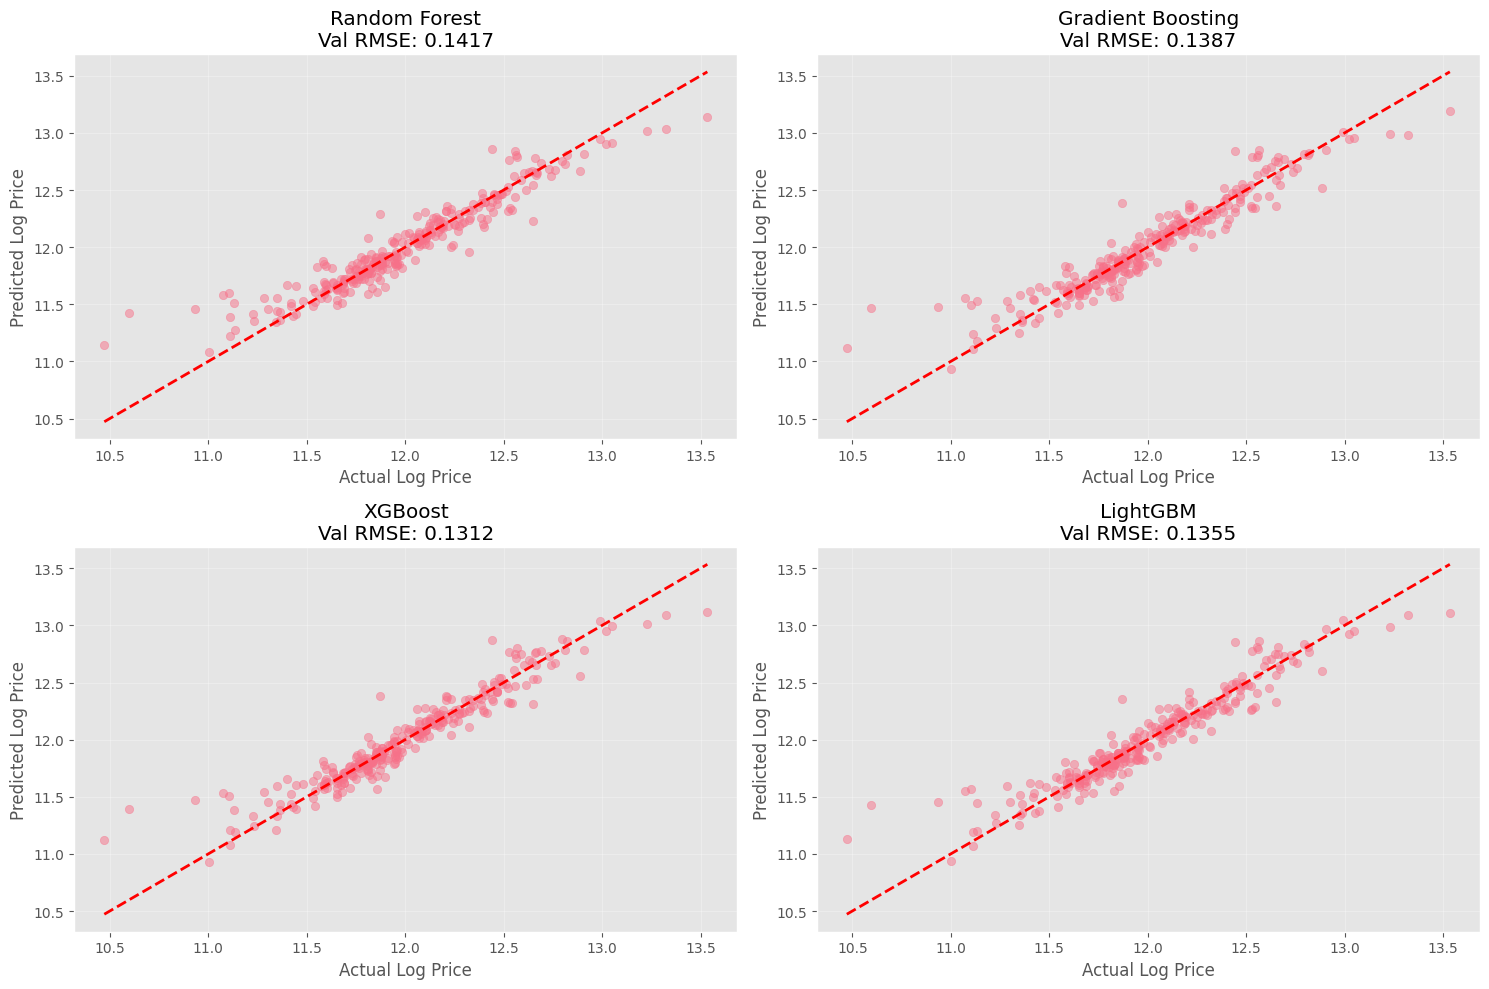


Лучшая модель: XGBoost
Validation RMSE лучшей модели: 0.131232


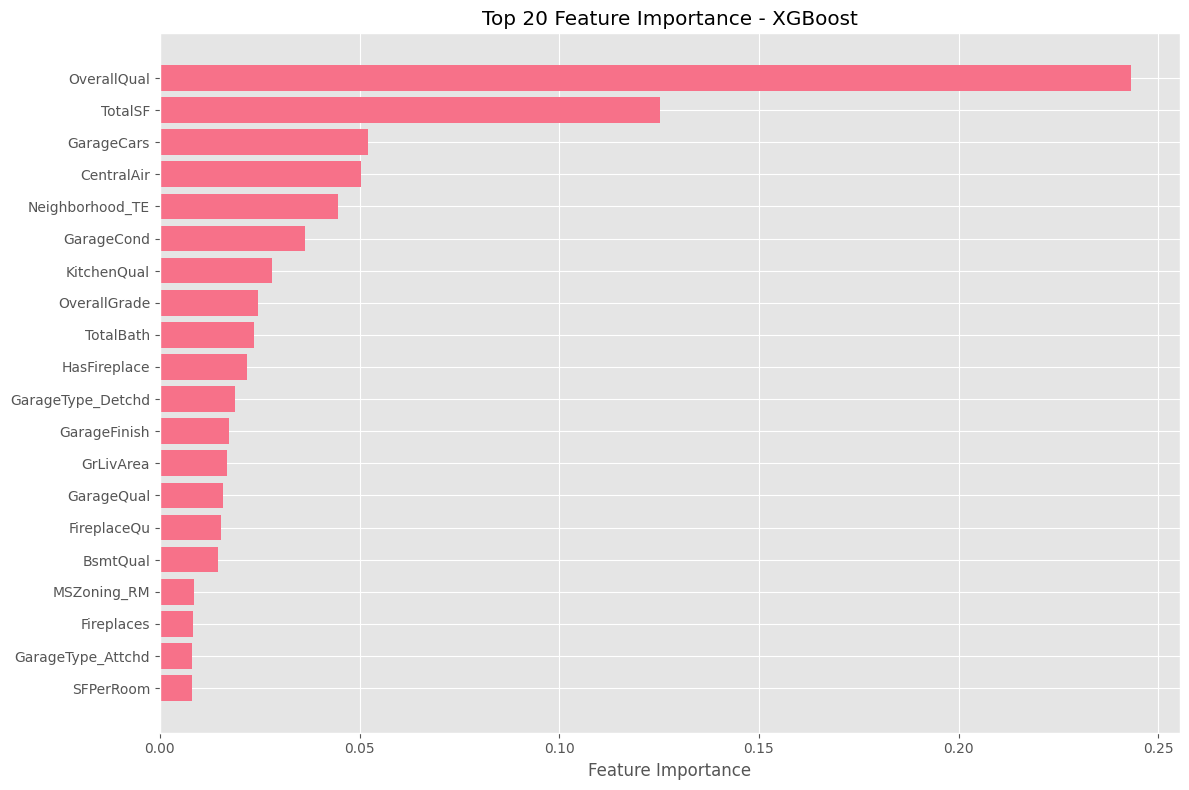

In [41]:
# 7.2. Обучение и анализ моделей
# Будем пробовать 4 разных алгоритма и сравним их
print("\n=== 8.2. Обучение и анализ моделей ===")

# Функция для вычисления RMSE в логарифмической шкале
def rmse_log(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Словарь для хранения результатов моделей
models_results = {}

# 1. Random Forest Regressor
print("\n1. Random Forest Regressor")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_split, y_train_split)
rf_train_pred = rf_model.predict(X_train_split)
rf_val_pred = rf_model.predict(X_val_split)

rf_train_rmse = rmse_log(y_train_split, rf_train_pred)
rf_val_rmse = rmse_log(y_val_split, rf_val_pred)

models_results['Random Forest'] = {
    'model': rf_model,
    'train_rmse': rf_train_rmse,
    'val_rmse': rf_val_rmse,
    'predictions': rf_val_pred
}

print(f"Train RMSE: {rf_train_rmse:.6f}")
print(f"Validation RMSE: {rf_val_rmse:.6f}")
print(f"Overfitting: {(rf_train_rmse - rf_val_rmse):.6f}")

# 2. Gradient Boosting Regressor
print("\n2. Gradient Boosting Regressor")
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model.fit(X_train_split, y_train_split)
gb_train_pred = gb_model.predict(X_train_split)
gb_val_pred = gb_model.predict(X_val_split)

gb_train_rmse = rmse_log(y_train_split, gb_train_pred)
gb_val_rmse = rmse_log(y_val_split, gb_val_pred)

models_results['Gradient Boosting'] = {
    'model': gb_model,
    'train_rmse': gb_train_rmse,
    'val_rmse': gb_val_rmse,
    'predictions': gb_val_pred
}

print(f"Train RMSE: {gb_train_rmse:.6f}")
print(f"Validation RMSE: {gb_val_rmse:.6f}")
print(f"Overfitting: {(gb_train_rmse - gb_val_rmse):.6f}")

# 3. XGBoost Regressor
print("\n3. XGBoost Regressor")
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_split, y_train_split)
xgb_train_pred = xgb_model.predict(X_train_split)
xgb_val_pred = xgb_model.predict(X_val_split)

xgb_train_rmse = rmse_log(y_train_split, xgb_train_pred)
xgb_val_rmse = rmse_log(y_val_split, xgb_val_pred)

models_results['XGBoost'] = {
    'model': xgb_model,
    'train_rmse': xgb_train_rmse,
    'val_rmse': xgb_val_rmse,
    'predictions': xgb_val_pred
}

print(f"Train RMSE: {xgb_train_rmse:.6f}")
print(f"Validation RMSE: {xgb_val_rmse:.6f}")
print(f"Overfitting: {(xgb_train_rmse - xgb_val_rmse):.6f}")

# 4. LightGBM Regressor
print("\n4. LightGBM Regressor")
lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train_split, y_train_split)
lgb_train_pred = lgb_model.predict(X_train_split)
lgb_val_pred = lgb_model.predict(X_val_split)

lgb_train_rmse = rmse_log(y_train_split, lgb_train_pred)
lgb_val_rmse = rmse_log(y_val_split, lgb_val_pred)

models_results['LightGBM'] = {
    'model': lgb_model,
    'train_rmse': lgb_train_rmse,
    'val_rmse': lgb_val_rmse,
    'predictions': lgb_val_pred
}

print(f"Train RMSE: {lgb_train_rmse:.6f}")
print(f"Validation RMSE: {lgb_val_rmse:.6f}")
print(f"Overfitting: {(lgb_train_rmse - lgb_val_rmse):.6f}")

# Сравнение результатов моделей
print("\n=== Сравнение моделей ===")
print("=" * 50)
print(f"{'Модель':<25} {'Train RMSE':<15} {'Val RMSE':<15} {'Overfitting':<15}")
print("=" * 50)

for model_name, results in models_results.items():
    print(f"{model_name:<25} {results['train_rmse']:<15.6f} {results['val_rmse']:<15.6f} "
          f"{(results['train_rmse'] - results['val_rmse']):<15.6f}")

print("=" * 50)

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(models_results.items()):
    ax = axes[idx]
    
    # График предсказаний vs фактические значения
    ax.scatter(y_val_split, results['predictions'], alpha=0.5)
    ax.plot([y_val_split.min(), y_val_split.max()], 
            [y_val_split.min(), y_val_split.max()], 'r--', lw=2)
    
    ax.set_xlabel('Actual Log Price')
    ax.set_ylabel('Predicted Log Price')
    ax.set_title(f'{model_name}\nVal RMSE: {results["val_rmse"]:.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ важности признаков для лучшей модели
best_model_name = min(models_results.items(), key=lambda x: x[1]['val_rmse'])[0]
best_model = models_results[best_model_name]['model']

print(f"\nЛучшая модель: {best_model_name}")
print(f"Validation RMSE лучшей модели: {models_results[best_model_name]['val_rmse']:.6f}")

# Визуализация важности признаков для лучшей модели
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Создаем DataFrame с важностями
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(importance_df)), importance_df['importance'][::-1])
    plt.yticks(range(len(importance_df)), importance_df['feature'][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    

## 7.3 Отбор самых важных  признаков 

In [42]:
print("\n=== Feature Selection: Cumulative 95% важности ===")

# 1. Cumulative 95% важности (самый надежный метод)
importances = best_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
cum_importance = np.cumsum(importances[sorted_idx])
n_features_95 = np.argmax(cum_importance >= 0.95) + 1
print(f"Фичи для 95% cumulative importance: {n_features_95} из {X_train_split.shape[1]}")

# 2. Selector для 95%
selector_95 = SelectFromModel(best_model, threshold=importances[sorted_idx[n_features_95-1]], prefit=True)

# 3. Проверяем качество на CV
X_train_selected_95 = selector_95.transform(X_train)
cv_scores_95 = cross_val_score(best_model, X_train_selected_95, y_log, 
                               cv=5, scoring='neg_root_mean_squared_error')
print(f"CV RMSE (95% фич): {-cv_scores_95.mean():.6f} ± {cv_scores_95.std():.6f}")

# 4. Имена выбранных фич
selected_features = X_train.columns[selector_95.get_support()].tolist()
print(f"\nВыбранные фичи ({len(selected_features)}):")
print(selected_features[:10], "..." if len(selected_features)>10 else "")

# 5. Финальные выборки с отобранными фичами
X_train_final = selector_95.transform(X_train)   # Для всего train
X_test_final = selector_95.transform(X_test)     # Для test

print(f"\n✅ Готово! X_train_final.shape: {X_train_final.shape}")
print(f"   X_test_final.shape:  {X_test_final.shape}")



=== Feature Selection: Cumulative 95% важности ===
Фичи для 95% cumulative importance: 73 из 199
CV RMSE (95% фич): 0.118778 ± 0.009711

Выбранные фичи (73):
['LotFrontage', 'LotArea', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterCond', 'BsmtQual', 'BsmtExposure'] ...

✅ Готово! X_train_final.shape: (1460, 73)
   X_test_final.shape:  (1459, 73)


## 7.4 Подбор гиперпараметров для XGBoost

In [43]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X_train_final, y_log, cv=5, scoring='neg_root_mean_squared_error')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best params:", best_params)
print("Best CV RMSE:", -study.best_value)



[I 2026-01-30 18:09:04,332] A new study created in memory with name: no-name-7f83f85a-7fbd-407c-afeb-89c8730636ff
[I 2026-01-30 18:09:05,452] Trial 0 finished with value: -0.1367044114697745 and parameters: {'n_estimators': 380, 'learning_rate': 0.16164856158165516, 'max_depth': 8, 'subsample': 0.962739672258414, 'colsample_bytree': 0.8388989599993881, 'reg_alpha': 0.5096909786234156, 'reg_lambda': 0.06039148157367191}. Best is trial 0 with value: -0.1367044114697745.
[I 2026-01-30 18:09:07,191] Trial 1 finished with value: -0.13127581430623164 and parameters: {'n_estimators': 294, 'learning_rate': 0.08172319093056582, 'max_depth': 10, 'subsample': 0.7820934169603536, 'colsample_bytree': 0.9096119333588817, 'reg_alpha': 0.678831498079033, 'reg_lambda': 0.3611125632999883}. Best is trial 1 with value: -0.13127581430623164.
[I 2026-01-30 18:09:08,557] Trial 2 finished with value: -0.14377674804080973 and parameters: {'n_estimators': 459, 'learning_rate': 0.26377668051973147, 'max_depth':

Best params: {'n_estimators': 924, 'learning_rate': 0.026548505333862576, 'max_depth': 3, 'subsample': 0.8096172244341115, 'colsample_bytree': 0.7358958714055293, 'reg_alpha': 0.03260840935905693, 'reg_lambda': 0.5229078097232808}
Best CV RMSE: 0.11760678610546924


# 8. Прогноз на тестовой выборке

In [46]:
# Обучаем финальную модель с оптимальными параметрами 
final_model = xgb.XGBRegressor(**best_params)
# Используем всю выборку для обучения
final_model.fit(X_train_final, y_log)

# Делаем предсказание модели на тестовой выборке
test_pred_log = final_model.predict(X_test_final)
# Переводим из логарифма обратно в доллары
test_pred = np.expm1(test_pred_log)
submission = pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': test_pred})
submission.to_csv('submission.csv', index=False)